In [1]:
#search for import above the current directory
import sys
import os
from pathlib import Path
cwd = Path().resolve().parent

sys.path.insert(1, os.path.join(cwd, 'Read Process FT Stat'))

import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import copy
import matplotlib.pyplot as plt

import dataAnalyzer_FTStat
import dataScreen_FTStat

In [2]:
#Determines the retention times in the target range with integTimes < 3000 ms (i.e., under TIC*IT control). Right hand limit = IT < 3000 ms; Left hand limit = relative Intensity > 20%. 

#If you run this multiple times, it will pick progressively smaller bounds; run it once with permissive bounds (e.g., 19 to 40) and then use those for subsequent processing. 
def getRHLimit(cDf):
	cDf = cDf[cDf['integTime'] < 3000]
	RHL = cDf['retTime'].max()
	
	maxUnsubIntensity = np.max(cDf['absIntensityUnsub'])
	cDf = cDf[cDf['absIntensityUnsub'] / maxUnsubIntensity > 0.2]
	RHL2 = cDf['retTime'].max()
	
	return min(RHL, RHL2)
	
def getLHLimit(cDf):
	cDf = cDf[cDf['integTime'] < 3000]
	LHL = cDf['retTime'].min()
	
	maxUnsubIntensity = np.max(cDf['absIntensityUnsub'])
	cDf = cDf[cDf['absIntensityUnsub'] / maxUnsubIntensity > 0.2]
	LHL2 = cDf['retTime'].min()
	
	return max(LHL, LHL2)

def getLimits(mergedDict):
	listDf = []
	LHLimits = []
	RHLimits = []
	for fileKey, fileData in mergedDict.items():
		cDf = fileData[0]
		listDf.append(cDf)
		LHL, RHL = getLHLimit(cDf), getRHLimit(cDf)
		LHLimits.append(LHL)
		RHLimits.append(RHL)
			
	return max(LHLimits), min(RHLimits)

In [3]:
#Folder with FT Statistic-ified files. All the files need to be processed using the same metrics.
fragKey = '316'
toProcess = {'20240801_316_ZeroEnrichment':{'smp Indices':[1,3,5]},
             '20240802_316_LGC':{'smp Indices':[1,3,5]},
             '20240802_316_AGI':{'smp Indices':[1,3,5]},
             '20241027_316_40':{'smp Indices':[1,4,6]},
             '20241027_316_17':{'smp Indices':[1,3]}}

outDict = {}
allMergedDict = {}
for folderPath, thisFolderParams in toProcess.items():
    fragmentDict = {'316':['Unsub','37Cl','37Cl-37Cl','37Cl-37Cl-37Cl']}
    fragmentMostAbundant = ['Unsub']

    massStr = []
    fragmentIsotopeList = []
    for i, v in fragmentDict.items():
        massStr.append(i)
        fragmentIsotopeList.append(v)
        
    cullByTime = True
    cullTimes = [(19.0,40.0)]
    #If cullTime left bound is <19.0, can mess with the program to determine cull times by identifying an abundant 'Unsub' peak eluting before the valves have been switched, e.g., due to another compound which makes the same fragment eluting earlier in direct elution mode

    rtnAllFilesDF, mergedDict, allOutputDict = dataAnalyzer_FTStat.calc_Folder_Output(folderPath, cullOn='TIC*IT',cullAmount = 3, 
                                                cullByTime=True, cullTimes = cullTimes, 
                                                fragmentIsotopeList = fragmentIsotopeList, 
                                                fragmentMostAbundant = fragmentMostAbundant, debug = True, fileExt = '.txt', 
                                                massStrList = list(fragmentDict.keys()),
                                                Microscans = 1,
                                                minNL_over_maxNL = 0.2,
                                                cull_on_IT = 3000)
    '''
    timeBounds = getLimits(mergedDict)
    print(timeBounds)
    
	
    rtnAllFilesDF, mergedDict, allOutputDict = dataAnalyzer_FTStat.calc_Folder_Output(folderPath, cullOn='TIC*IT',cullAmount = 3,
                                            cullByTime=True, cullTimes = [timeBounds], 
                                            fragmentIsotopeList = fragmentIsotopeList, 
                                            fragmentMostAbundant = fragmentMostAbundant, debug = True, fileExt = '.txt', 
                                            massStrList = list(fragmentDict.keys()),
                                            Microscans = 1,
                                            minNL_over_maxNL = 0)
    '''
                                            
                                            
    
    dataScreen_FTStat.zeroCountsScreen(mergedDict, fragmentDict[fragKey])
    dataScreen_FTStat.RSESNScreen(allOutputDict)
    
    outDict[folderPath] = rtnAllFilesDF
    allMergedDict[folderPath] = copy.deepcopy(mergedDict)

20240801_120_DDT_SIG_EI_Reservoir_316_1e6_1.txt
20240801_121_DDT_SIG_EI_Reservoir_316_1e6_2.txt
20240801_122_DDT_SIG_EI_Reservoir_316_1e6_3.txt
20240801_123_DDT_SIG_EI_Reservoir_316_1e6_4.txt
20240801_124_DDT_SIG_EI_Reservoir_316_1e6_5.txt
20240801_125_DDT_SIG_EI_Reservoir_316_1e6_6.txt
20240801_126_DDT_SIG_EI_Reservoir_316_1e6_7.txt
20240802_137_DDT_SIG_EI_316_1.txt
20240802_138_DDT_LGC_EI_316_2.txt
20240802_139_DDT_SIG_EI_316_3.txt
20240802_140_DDT_LGC_EI_316_4.txt
20240802_141_DDT_SIG_EI_316_5.txt
20240802_142_DDT_LGC_EI_316_6.txt
20240802_143_DDT_SIG_EI_316_7.txt
20240802_158_DDT_SIG_EI_Reservoir_316_1.txt
20240802_159_DDT_AGI_EI_Reservoir_316_2.txt
20240802_160_DDT_SIG_EI_Reservoir_316_3.txt
20240802_161_DDT_AGI_EI_Reservoir_316_4.txt
20240802_162_DDT_SIG_EI_Reservoir_316_5.txt
20240802_163_DDT_AGI_EI_Reservoir_316_6.txt
20240802_164_DDT_SIG_EI_Reservoir_316_7.txt
20241014_52_DDT_25uM_RES_316.txt
20241014_53_DDT_40_RES_316_1.txt
20241014_54_DDT_25uM_RES_316_2.txt
20241014_60_DDT_2

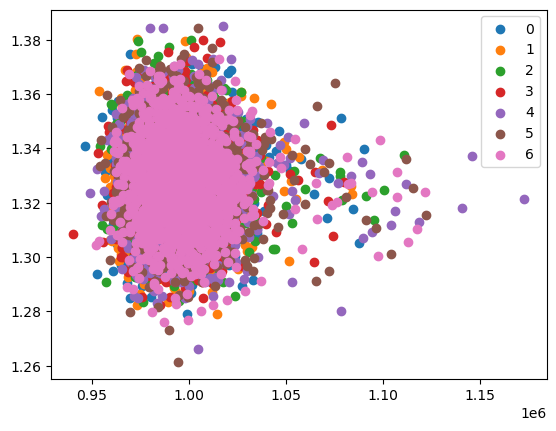

In [4]:
#file 4 has weird tic, and weird TIC*IT
zero = allMergedDict['20240801_316_ZeroEnrichment']
for fileIdx, (file_key, file_data) in enumerate(zero.items()):
    if fileIdx not in [0,1,2,3,4,5,6]:
        continue
    this_df = file_data[0]
    plt.scatter(this_df['TIC*IT'], this_df['37Cl/Unsub'], label = fileIdx)
plt.legend()

In [5]:
outDict['20240802_316_AGI'].groupby('IsotopeRatio')['RelStdError'].mean().reset_index()

,IsotopeRatio,RelStdError
0,37Cl-37Cl-37Cl/Unsub,0.000580
1,37Cl-37Cl/Unsub,0.000327
2,37Cl/Unsub,0.000277


In [6]:
for thisExp, thisData in allMergedDict.items():
	for thisFile, thisFileData in thisData.items():
		cDf = thisFileData[0]
		print(thisFile)
		print(str((cDf['retTime'].min(), cDf['retTime'].max())))
		print(len(cDf))

20240801_120_DDT_SIG_EI_Reservoir_316_1e6_1.txt
(19.34, 27.57)
1591
20240801_121_DDT_SIG_EI_Reservoir_316_1e6_2.txt
(19.36, 27.66)
1618
20240801_122_DDT_SIG_EI_Reservoir_316_1e6_3.txt
(19.34, 27.58)
1618
20240801_123_DDT_SIG_EI_Reservoir_316_1e6_4.txt
(19.35, 27.46)
1608
20240801_124_DDT_SIG_EI_Reservoir_316_1e6_5.txt
(19.32, 27.42)
1626
20240801_125_DDT_SIG_EI_Reservoir_316_1e6_6.txt
(19.34, 27.33)
1599
20240801_126_DDT_SIG_EI_Reservoir_316_1e6_7.txt
(19.34, 27.23)
1618
20240802_137_DDT_SIG_EI_316_1.txt
(19.33, 26.86)
1598
20240802_138_DDT_LGC_EI_316_2.txt
(19.33, 26.65)
1580
20240802_139_DDT_SIG_EI_316_3.txt
(19.33, 26.65)
1585
20240802_140_DDT_LGC_EI_316_4.txt
(19.34, 26.6)
1591
20240802_141_DDT_SIG_EI_316_5.txt
(19.32, 26.51)
1585
20240802_142_DDT_LGC_EI_316_6.txt
(19.32, 26.39)
1566
20240802_143_DDT_SIG_EI_316_7.txt
(19.32, 26.42)
1577
20240802_158_DDT_SIG_EI_Reservoir_316_1.txt
(19.33, 27.45)
1768
20240802_159_DDT_AGI_EI_Reservoir_316_2.txt
(19.37, 26.73)
1630
20240802_160_DDT_SI

In [7]:
allFolderValues = {}
for folderPath, folderParams in toProcess.items():
	thisRtnAllFilesDf = outDict[folderPath]
	sampleOutputDict = dataAnalyzer_FTStat.folderOutputToDict(thisRtnAllFilesDf)

	file_keys = list(sampleOutputDict.keys())
	sub_keys = list(sampleOutputDict[file_keys[0]][fragKey].keys())
	  
	thisFolderValues = {}
	for subIdx, subKey in enumerate(sub_keys):
		# Select the data for one subKey ('13C/Unsub') across all files
		averages = [sampleOutputDict[file][fragKey][subKey]['Average'] for file in sampleOutputDict]
		rel_std_errors = [sampleOutputDict[file][fragKey][subKey]['RelStdError'] for file in sampleOutputDict]
				
		# Indices for samples
		sample_indices = folderParams['smp Indices']

		# Initialize lists for standardized values and propagated errors
		standardized_deltas = []
		propagated_errors = []

		# Function to calculate the propagated error
		def calculate_propagated_error(sample_error, std1_error, std2_error):
			return np.sqrt(sample_error**2 + 1/np.sqrt(2) * (std1_error/2 + std2_error/2)**2)

		# Iterate through sample indices to calculate standardized values and errors
		for idx in sample_indices:
			sample_value = averages[idx]
			std1_value, std2_value = averages[idx - 1], averages[idx + 1]
			
			standardized_value = (sample_value / std1_value + sample_value / std2_value) / 2
			standardized_delta = 1000 * (standardized_value-1)
			
			sample_error = rel_std_errors[idx]
			std1_error, std2_error = rel_std_errors[idx - 1], rel_std_errors[idx + 1]
			
			propagated_error = calculate_propagated_error(sample_error, std1_error, std2_error)
			propagated_error*= 1000
			
			standardized_deltas.append(standardized_delta)
			propagated_errors.append(propagated_error)
			
	
		thisFolderValues[subKey] = {'Deltas': copy.deepcopy(standardized_deltas), 
							  'Propagated Acquisition Errors':copy.deepcopy(propagated_errors),
							  'Mean Delta' : np.array(standardized_deltas).mean(),
							  'Experimental Reproducibility': np.array(standardized_deltas).std()/ np.sqrt(len(standardized_deltas))}
		
	allFolderValues[folderPath] = thisFolderValues

In [8]:
# --- Step 1: Collect all reproducibilities grouped by Ratio Key ---
from collections import defaultdict

grouped_repro = defaultdict(list)

for folder, ratios in allFolderValues.items():
    if folder in ['20241027_316_17', '20241027_316_40']:
        print("FOUND")
        continue
    for ratio_key, metrics in ratios.items():
        grouped_repro[ratio_key].append(metrics['Experimental Reproducibility'])

# --- Step 2: Compute mean for each Ratio Key ---
mean_repro_by_key = {k: sum(v) / len(v) for k, v in grouped_repro.items()}

# --- Step 3: Add it back to each entry ---
for folder, ratios in allFolderValues.items():
    for ratio_key, metrics in ratios.items():

        if folder in ['20241027_316_17', '20241027_316_40']:
            this_MR = metrics['Experimental Reproducibility']
        else:
            this_MR = mean_repro_by_key[ratio_key]
        metrics['Mean Experimental Reproducibility'] = this_MR

FOUND
FOUND


In [9]:
import json

# Save to JSON file
with open('316_data.json', 'w') as f:
    json.dump(allFolderValues, f, indent=2)

In [10]:
for ratio_key, ratio_data in allFolderValues['20241027_316_17'].items():
    print(ratio_key)
    this_prop_ae = np.mean(ratio_data['Propagated Acquisition Errors']) / np.sqrt(len(ratio_data['Propagated Acquisition Errors']))
    this_error = max(this_prop_ae, ratio_data['Experimental Reproducibility'])
    print(ratio_data['Mean Delta'])
    print(this_error)

37Cl-37Cl-37Cl/Unsub
20.67325382182694
2.6836092791104798
37Cl-37Cl/Unsub
10.993902772792774
1.4479538798260592
37Cl/Unsub
2.2709849570804463
1.2052053374162868


In [11]:
# Step 1: Flatten the data
flattened_data = []
for folder_name, ratios in allFolderValues.items():
    for ratio_key, metrics in ratios.items():
        entry = {
            'Folder Name': folder_name,
            'Ratio Key': ratio_key,
            'Deltas': metrics['Deltas'],
            'Propagated Acquisition Errors': metrics['Propagated Acquisition Errors'],
            'Mean Delta': metrics['Mean Delta'],
            'Experimental Reproducibility': metrics['Experimental Reproducibility']
        }
        flattened_data.append(entry)

# Step 2: Create a pandas DataFrame
df = pd.DataFrame(flattened_data)

# Step 3: Expand lists into separate columns
df = df.explode(['Deltas', 'Propagated Acquisition Errors']).reset_index(drop=True)

# Step 4: Round numerical columns to three decimal places
#Explode messes with the datatypes for these; fix
df['Deltas'] = pd.to_numeric(df['Deltas'], errors='coerce')
df['Propagated Acquisition Errors'] = pd.to_numeric(df['Propagated Acquisition Errors'], errors='coerce')
#now round
columns_to_round = ['Deltas', 'Propagated Acquisition Errors', 'Mean Delta', 'Experimental Reproducibility']
df[columns_to_round] = df[columns_to_round].round(2)

df.to_csv("316 Data.csv", index=False)

In [12]:
df['Experimental Reproducibility'] * np.sqrt(3) / df['Propagated Acquisition Errors']

0     1.496834
1     1.515544
2     1.496834
3     1.393171
4     1.424131
5     1.424131
6     1.048347
7     1.048347
8     1.048347
9     0.799408
10    0.809790
11    0.779423
12    0.078730
13    0.078730
14    0.078730
15    0.655371
16    0.638124
17    0.655371
18    1.162297
19    1.177795
20    1.147202
21    0.948504
22    0.948504
23    0.905390
24    0.643333
25    0.608558
26    0.608558
27    0.840703
28    0.737232
29    0.794255
30    0.631388
31    0.554856
32    0.593388
33    0.980800
34    0.935706
35    0.919846
36    0.510929
37    0.412393
38    0.373580
39    0.371757
40    0.424632
41    0.353860
dtype: float64

20240802_158_DDT_SIG_EI_Reservoir_316_1.txt
20240802_159_DDT_AGI_EI_Reservoir_316_2.txt
20240802_160_DDT_SIG_EI_Reservoir_316_3.txt
20240802_161_DDT_AGI_EI_Reservoir_316_4.txt
20240802_162_DDT_SIG_EI_Reservoir_316_5.txt
20240802_163_DDT_AGI_EI_Reservoir_316_6.txt
20240802_164_DDT_SIG_EI_Reservoir_316_7.txt
1.08
0.88
1.06
0.90


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


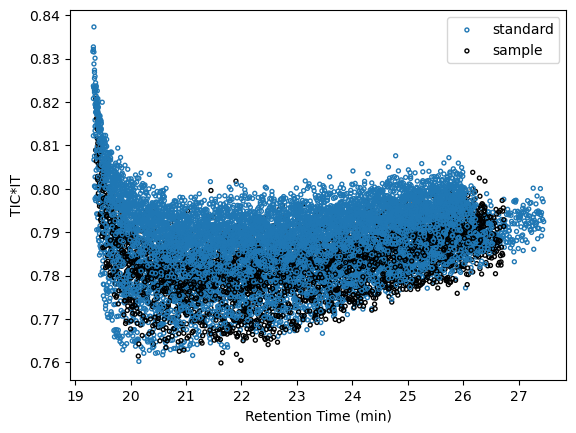

In [13]:
thisSamplesDfs = allMergedDict['20241027_316_40']
thisSamplesDfs = allMergedDict['20241027_316_17']
thisSamplesDfs = allMergedDict['20240802_316_LGC']
thisSamplesDfs = allMergedDict['20240802_316_AGI']
fig, ax = plt.subplots()

ticMax = []
for idx, (fileKey, fileDf) in enumerate(thisSamplesDfs.items()):
	print(fileKey)
	cDf = fileDf[0]
	if idx in [1,3]:
		c = 'k'
		label = 'sample'
	else:
		c = 'tab:blue'
		label = 'standard'
	sumIntensities = cDf['absIntensityUnsub'] + cDf['absIntensity37Cl'] + cDf['absIntensity37Cl-37Cl'] + cDf['absIntensity37Cl-37Cl-37Cl']
	#Can also plot cDf['TIC*IT']
	plt.scatter(cDf['retTime'], sumIntensities / cDf['tic'], s= 8, alpha = 1, edgecolor = c, facecolor = 'None', label = label)
	
	ticMax.append(cDf['tic'].max())
	
for idx in [1,3]:
	print(f'{ticMax[idx] / ticMax[idx - 1]:.2f}')
	print(f'{ticMax[idx] / ticMax[idx + 1]:.2f}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_xlabel("Retention Time (min)")
#ax.set_ylabel('Extracted Peak Intensities / \nTotal Ion Current')
ax.set_ylabel('TIC*IT')

fig.savefig('TICIT_316.eps', bbox_inches = 'tight')

In [14]:
for fileKey, fileData in outDict.items():
    print(fileKey)
    for IsotopeRatio in ['37Cl/Unsub','37Cl-37Cl/Unsub','37Cl-37Cl-37Cl/Unsub']:
        thisData = fileData[fileData['IsotopeRatio'] == IsotopeRatio]
        print(IsotopeRatio)
        print(f'{1000*thisData["RelStdError"].mean():.4f}')

20240801_316_ZeroEnrichment
37Cl/Unsub
0.2887
37Cl-37Cl/Unsub
0.3481
37Cl-37Cl-37Cl/Unsub
0.6139
20240802_316_LGC
37Cl/Unsub
0.2833
37Cl-37Cl/Unsub
0.3384
37Cl-37Cl-37Cl/Unsub
0.6019
20240802_316_AGI
37Cl/Unsub
0.2771
37Cl-37Cl/Unsub
0.3270
37Cl-37Cl-37Cl/Unsub
0.5802
20241027_316_40
37Cl/Unsub
1.3152
37Cl-37Cl/Unsub
1.6884
37Cl-37Cl-37Cl/Unsub
2.7965
20241027_316_17
37Cl/Unsub
1.3308
37Cl-37Cl/Unsub
1.5759
37Cl-37Cl-37Cl/Unsub
2.9281


c:\Users\tacse\.conda\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\Users\tacse\.conda\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\tacse\.conda\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\Users\tacse\.conda\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\tacse\.conda\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\Users\tacse\.conda\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  

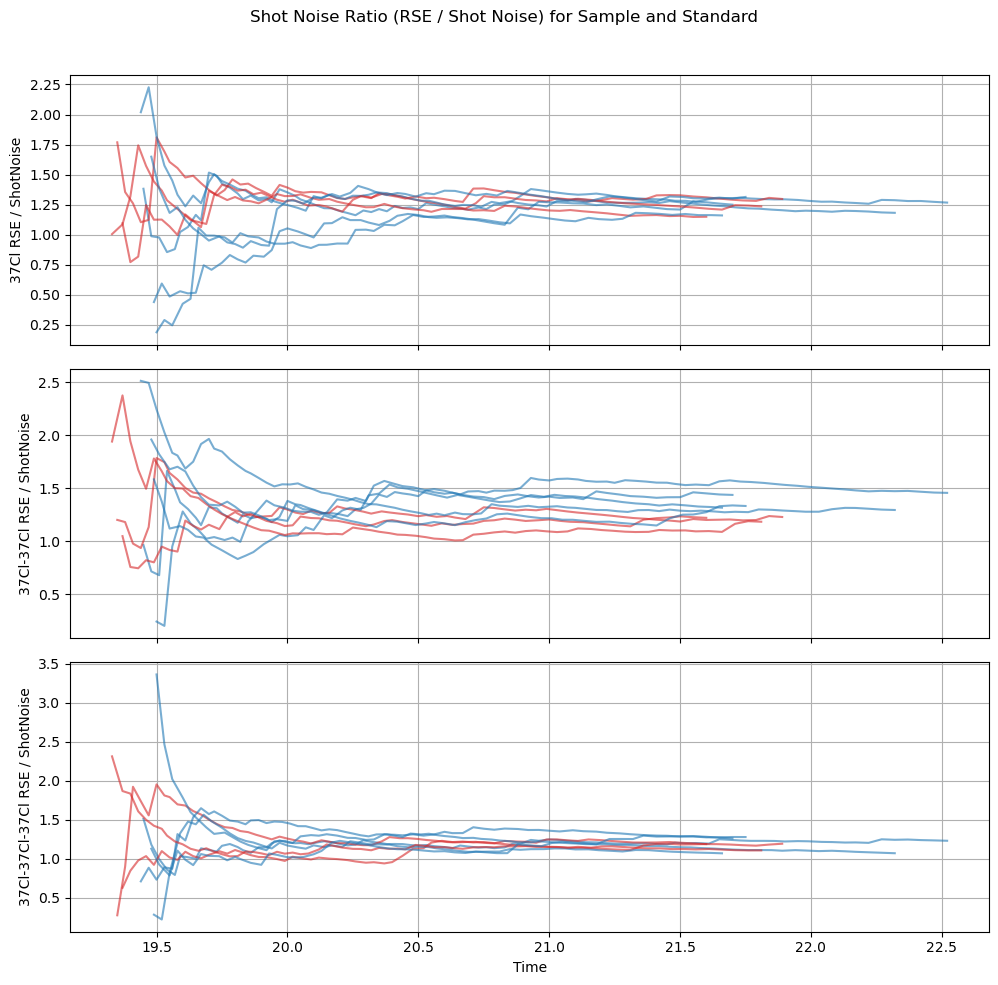

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
isoKeys = ['37Cl', '37Cl-37Cl', '37Cl-37Cl-37Cl']
colors = {'sample': 'tab:red', 'standard': 'tab:blue'}

for smpKey, smpData in allMergedDict.items():
    if smpKey != '20241027_316_40':
        continue

    for fileIdx, (fileKey, fileData) in enumerate(smpData.items()):
        cDf = fileData[0]
        time = cDf['retTime'].values

        label = 'sample' if fileIdx in [1, 4, 6] else 'standard'
        color = colors[label]

        for i, isoKey in enumerate(isoKeys):
            thisRat = isoKey + '/Unsub'
            thisSeries = np.array(cDf[thisRat])
            counts1 = np.array(cDf['counts' + isoKey])
            counts2 = np.array(cDf['countsUnsub'])

            cum_mean = np.cumsum(thisSeries) / np.arange(1, len(thisSeries)+1)
            cum_se = np.array([np.std(thisSeries[:j+1], ddof=1)/np.sqrt(j+1) for j in range(len(thisSeries))])
            cum_rse = cum_se / cum_mean
            cum_counts1 = np.cumsum(counts1)
            cum_counts2 = np.cumsum(counts2)
            shot_noise = np.sqrt(1 / cum_counts1 + 1 / cum_counts2)
            ratio = cum_rse / shot_noise

            axes[i].plot(time, ratio, label=f'{label} {fileKey}', color=color, alpha=0.6)

# Formatting
for i, ax in enumerate(axes):
    ax.set_ylabel(f'{isoKeys[i]} RSE / ShotNoise')
    ax.grid(True)
    #ax.legend(fontsize='small', loc='upper right')
axes[-1].set_xlabel("Time")
fig.suptitle("Shot Noise Ratio (RSE / Shot Noise) for Sample and Standard")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
toProcess = {'20240802_316_LGC':{'smp Indices':[1,3,5]},
             '20240802_316_AGI':{'smp Indices':[1,3,5]},
             '20241027_316_40':{'smp Indices':[1,4,6]},
             '20241027_316_17':{'smp Indices':[1,3]}}

for runKey, runData in toProcess.items():
    print(runKey)
    this_file_names = list(allMergedDict[runKey].keys())
    smpIndices = runData['smp Indices']
    for isoKey in ['37Cl','37Cl-37Cl','37Cl-37Cl-37Cl']:
        all_alphas = []
        for fileIdx, (fileKey, fileData) in enumerate(allMergedDict[runKey].items()):
            if fileIdx in smpIndices:
                std1 = allMergedDict[runKey][this_file_names[fileIdx-1]][0]
                std2 = allMergedDict[runKey][this_file_names[fileIdx-1]][0]
                smp = fileData[0]

                this_R = isoKey + '/Unsub'

                std_1_r = std1[this_R].values.mean()
                std_2_r = std2[this_R].values.mean()
                smp_r = smp[this_R].values

                scan_by_scan_alpha = smp_r / ((std_1_r + std_2_r) / 2)
                all_alphas += list(scan_by_scan_alpha)
                print(len(scan_by_scan_alpha))
                #print(np.mean(scan_by_scan_alpha))

        mean_alpha = np.mean(all_alphas)
        mean_delta = 1000 * (mean_alpha - 1)
        stdev_alpha = np.std(all_alphas)
        stderror_alpha = np.std(all_alphas) / np.sqrt(len(all_alphas))
        rse_alpha = stderror_alpha / mean_alpha
        rse_delta = rse_alpha * 1000

        print(f'{isoKey} Mean Delta: {mean_delta:.4f} +/- {rse_delta:4f}')

20240802_316_LGC
1580
1591
1566
37Cl Mean Delta: 0.6908 +/- 0.165347
1580
1591
1566
37Cl-37Cl Mean Delta: -0.2661 +/- 0.195983
1580
1591
1566
37Cl-37Cl-37Cl Mean Delta: -0.6740 +/- 0.346478
20240802_316_AGI
1630
1595
1510
37Cl Mean Delta: 1.0759 +/- 0.161331
1630
1595
1510
37Cl-37Cl Mean Delta: 1.5131 +/- 0.190802
1630
1595
1510
37Cl-37Cl-37Cl Mean Delta: 3.5472 +/- 0.338437
20241027_316_40
72
62
70
37Cl Mean Delta: -0.6035 +/- 0.781724
72
62
70
37Cl-37Cl Mean Delta: -0.7191 +/- 0.918588
72
62
70
37Cl-37Cl-37Cl Mean Delta: 8.4206 +/- 1.628399
20241027_316_17
105
83
37Cl Mean Delta: 2.3834 +/- 0.852974
105
83
37Cl-37Cl Mean Delta: 11.3277 +/- 1.090699
105
83
37Cl-37Cl-37Cl Mean Delta: 19.5912 +/- 1.994730


In [19]:
allMergedDict['20241027_316_17']

{'20241014_40_DDT_25uM_RES_316.txt': [      massUnsub  retTime       tic  relIntensityUnsub  scanNumber  \
  188  315.937531    19.41  549215.0              75.42       189.0   
  189  315.937561    19.44  583385.0              77.21       190.0   
  190  315.937592    19.47  603001.0              75.82       191.0   
  191  315.937469    19.50  621444.0              73.83       192.0   
  192  315.937531    19.53  634214.0              72.56       193.0   
  ..          ...      ...       ...                ...         ...   
  288  315.937561    22.79  373418.0              73.87       289.0   
  289  315.937561    22.84  369712.0              74.59       290.0   
  290  315.937500    22.89  364164.0              73.36       291.0   
  291  315.937561    22.94  361505.0              74.62       292.0   
  292  315.937408    22.98  356505.0              75.02       293.0   
  
       absIntensityUnsub  integTime     TIC*IT     ftRes  peakNoiseUnsub  ...  \
  188           140634.0   2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


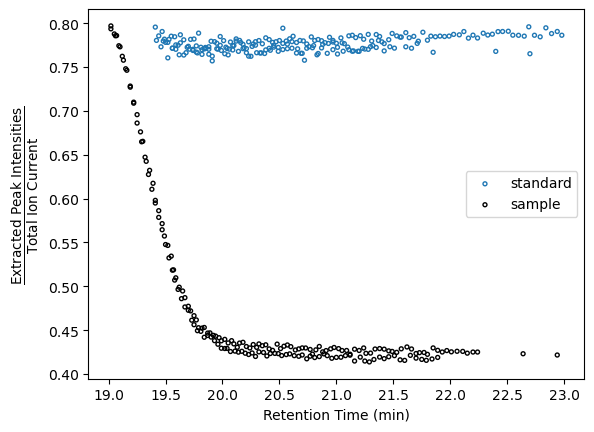

In [25]:
fig, ax = plt.subplots()

for idx, (file_key, file_data) in enumerate(allMergedDict['20241027_316_17'].items()):
    cDf = file_data[0]
    if idx in [1,3]:
        c = 'k'
        label = 'sample'
    else:
        c = 'tab:blue'
        label = 'standard'
        

    sumIntensities = cDf['absIntensityUnsub'] + cDf['absIntensity37Cl'] + cDf['absIntensity37Cl-37Cl'] + cDf['absIntensity37Cl-37Cl-37Cl']
    plt.scatter(cDf['retTime'],  sumIntensities / cDf['tic'], s= 8,alpha = 1, edgecolor = c, facecolor = 'None',label = label)
    

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_xlabel("Retention Time (min)")
ax.set_ylabel(r'$\frac{\mathrm{Extracted\ Peak\ Intensities}}{\mathrm{Total\ Ion\ Current}}$', fontsize = 14)

fig.savefig('Relative_Intensity_Deep_316.eps', bbox_inches = 'tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


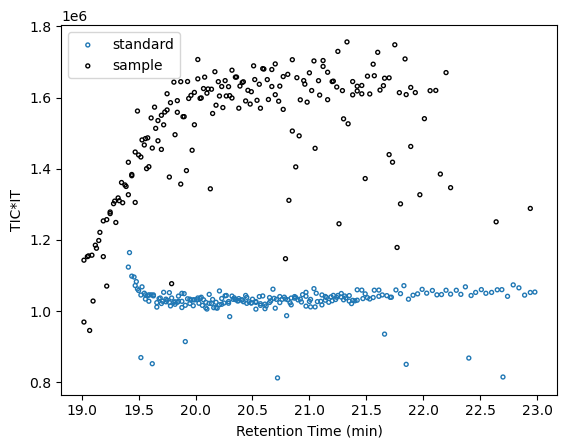

In [29]:
fig, ax = plt.subplots()

for idx, (file_key, file_data) in enumerate(allMergedDict['20241027_316_17'].items()):
    cDf = file_data[0]
    if idx in [1,3]:
        c = 'k'
        label = 'sample'
    else:
        c = 'tab:blue'
        label = 'standard'
        

    sumIntensities = cDf['absIntensityUnsub'] + cDf['absIntensity37Cl'] + cDf['absIntensity37Cl-37Cl'] + cDf['absIntensity37Cl-37Cl-37Cl']
    plt.scatter(cDf['retTime'],  cDf['TIC*IT'], s= 8,alpha = 1, edgecolor = c, facecolor = 'None',label = label)
    

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_xlabel("Retention Time (min)")
ax.set_ylabel('TIC*IT')

fig.savefig('TICIT_Deep_316.eps', bbox_inches = 'tight')

Text(0, 0.5, 'TIC*IT')

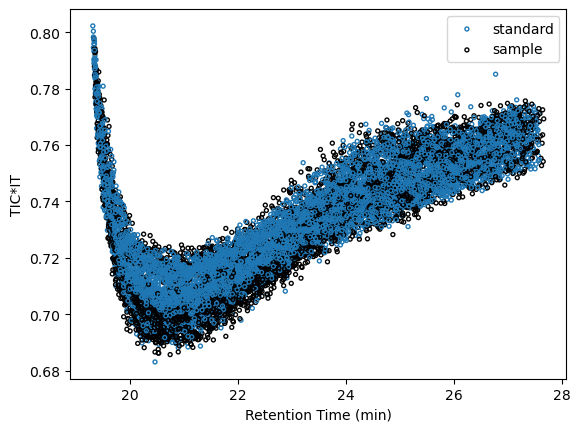

In [35]:
fig, ax = plt.subplots()

for idx, (file_key, file_data) in enumerate(allMergedDict['20240801_316_ZeroEnrichment'].items()):
    cDf = file_data[0]
    if idx in [1,3,5]:
        c = 'k'
        label = 'sample'
    else:
        c = 'tab:blue'
        label = 'standard'
        

    sumIntensities = cDf['absIntensityUnsub'] + cDf['absIntensity37Cl'] + cDf['absIntensity37Cl-37Cl'] + cDf['absIntensity37Cl-37Cl-37Cl']
    plt.scatter(cDf['retTime'],  sumIntensities / cDf['tic'], s= 8,alpha = 1, edgecolor = c, facecolor = 'None',label = label)
    

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_xlabel("Retention Time (min)")
ax.set_ylabel('TIC*IT')